In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mutual_info_score
from sklearn import metrics
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import tensorflow as tf

Here we preprocess and prepare the data by encoding categorical variables and removing null values. We have some data loading here that was used in an attempt to prevent the model from overfitting by refactoring the model to PyTorch.

In [13]:
df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')
df['score_text'] = df['score_text'].replace({'High': 2, 'Medium': 1, 'Low': 0})
df['score_text'] = df['score_text'].fillna(0)
df['v_score_text'] = df['v_score_text'].replace({'High': 2, 'Medium': 1, 'Low': 0})
df['v_score_text'] = df['v_score_text'].fillna(0)
df = df[df['race'].isin(['Caucasian', 'African-American'])]
df['race'] = df['race'].replace({'Caucasian': 1, 'African-American': 0})

filtered_unpriv = df[df['race'] == 0]
prep_unpriv = filtered_unpriv[['id','two_year_recid']]
filtered_priv = df[df['race'] == 1]
prep_priv = filtered_priv[['id','two_year_recid']]


Xdf = df[['id', 'age', 'juv_fel_count', 'juv_misd_count', 'is_recid', 'decile_score','juv_other_count', 'priors_count', 'v_score_text', 'is_violent_recid']]
Ydf = df[['two_year_recid']]
Sdf = df[['race']]

X = torch.tensor(Xdf.values)
Y = torch.tensor(Ydf.values)
S = torch.tensor(Sdf.values)

(X_train, X_test, Y_train, Y_test, S_train, S_test) = train_test_split(X, Y, S, test_size=0.1, random_state=42)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(S_train.shape)
print(S_test.shape)
print()


class ModelDataset(Dataset):
    def __init__(self, features, labels, sensitive_attributes, transform=None):
        self.features = features
        self.labels = labels.reshape(-1, 1)
        self.sensitive_attributes = sensitive_attributes
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        sensitive_attribute = self.sensitive_attributes[idx]

        if self.transform:
            feature = self.transform(feature)

        return feature, label, sensitive_attribute

train_dataset = ModelDataset(X_train, Y_train, S_train)
test_dataset = ModelDataset(X_test, Y_test, S_test)

batch_size = 32
test_batch_size = len(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)

n_feature = torch.empty((batch_size, 10))
n_label = torch.empty((batch_size, 1))
n_senstive = torch.empty((batch_size, 1))

test_feature = torch.empty((test_batch_size, 10))
test_label = torch.empty((test_batch_size, 1))
test_senstive = torch.empty((test_batch_size, 1))





torch.Size([5535, 10])
torch.Size([5535, 1])
torch.Size([615, 10])
torch.Size([615, 1])
torch.Size([5535, 1])
torch.Size([615, 1])




Make a Logistic Regression model that predicts two_year_recidivism without any prejudice remover. Notice that without any prejudice removal, the model predicts recidivism more accurately for Caucasians compared to African Americans.

In [14]:
X = df[['id', 'age', 'juv_fel_count', 'juv_misd_count', 'is_recid', 'decile_score','juv_other_count', 'priors_count', 'v_score_text', 'is_violent_recid', 'race']].copy()
X = X.fillna(0)
Y = df['two_year_recid'].copy()
unfair_model = LogisticRegression(max_iter=1000)
unfair_model.fit(X, Y)

target_u = df['two_year_recid']

priv = X[X['race'] == 1]
unpriv = X[X['race'] == 0]


# un = pd.DataFrame({
#     'id': unpriv['id'],
#     'two_year_recid': unpriv['t']
# })

priv_pred = unfair_model.predict(priv)
unpriv_pred = unfair_model.predict(unpriv)

accuracy_priv = accuracy_score(Y[X['race'] == 1], priv_pred)
accuracy_unpriv = accuracy_score(Y[X['race'] == 0], unpriv_pred)

print("Accuracy for privileged group (race == 1):", accuracy_priv)
print("Accuracy for unprivileged group (race == 0):", accuracy_unpriv)

Accuracy for privileged group (race == 1): 0.9759576202118989
Accuracy for unprivileged group (race == 0): 0.963474025974026


Without the `is_recid` feature, the accuracies from the Logistic Regression model for the privileged and unprivileged groups both decrease significantly, while the difference between the two accuracies remains almost the same.

In [15]:
X = df[['id', 'age', 'juv_fel_count', 'juv_misd_count', 'decile_score','juv_other_count', 'priors_count', 'v_score_text', 'is_violent_recid', 'race']].copy()
X = X.fillna(0)
Y = df['two_year_recid'].copy()
unfair_model = LogisticRegression(max_iter=1000)
unfair_model.fit(X, Y)
priv = X[X['race'] == 1]
unpriv = X[X['race'] == 0]

priv_pred = unfair_model.predict(priv)
unpriv_pred = unfair_model.predict(unpriv)

accuracy_priv = accuracy_score(Y[X['race'] == 1], priv_pred)
accuracy_unpriv = accuracy_score(Y[X['race'] == 0], unpriv_pred)

print("Accuracy for privileged group (race == 1):", accuracy_priv)
print("Accuracy for unprivileged group (race == 0):", accuracy_unpriv)

Accuracy for privileged group (race == 1): 0.7224938875305623
Accuracy for unprivileged group (race == 0): 0.7126623376623377



Store the class Y, the non-sensitive features X, and the sensitive feature S separately.

In [16]:
non_sensitive_features = ['id', 'age', 'juv_fel_count', 'is_recid','juv_other_count', 'priors_count', 'v_score_text', 'is_violent_recid']
X = df[non_sensitive_features].copy()
Y = df['two_year_recid'].copy()
S = df['race'].copy()
print(X)
print(Y)
print(S)

         id  age  juv_fel_count  is_recid  juv_other_count  priors_count  \
1         3   34              0         1                0             0   
2         4   24              0         1                1             4   
3         5   23              0         0                0             1   
6         8   41              0         1                0            14   
8        10   39              0         0                0             0   
...     ...  ...            ...       ...              ...           ...   
7207  10994   30              0         1                0             0   
7208  10995   20              0         0                0             0   
7209  10996   23              0         0                0             0   
7210  10997   23              0         0                0             0   
7212  11000   33              0         0                0             3   

      v_score_text  is_violent_recid  
1                0                 1  
2        

Here we implement the prejudice removal regularizer as a loss function for our logistic regression classifier. To make the loss function compatible with our model, we normalize the training and validation data.

In [24]:
def PRLOSS(unpriv, priv, learning_rate):
    unpriv_float = tf.cast(unpriv, dtype=tf.float32)
    priv_float = tf.cast(priv, dtype=tf.float32)

    n_unpriv = tf.cast(tf.shape(unpriv_float)[0], dtype=tf.float32)
    n_priv = tf.cast(tf.shape(priv_float)[0], dtype=tf.float32)

    n_unpriv = tf.maximum(n_unpriv, 1.0)
    n_priv = tf.maximum(n_priv, 1.0)

    Dxisi = tf.stack([n_priv, n_unpriv], axis=0)

    y_pred_priv = tf.reduce_sum(priv_float)
    y_pred_unpriv = tf.reduce_sum(unpriv_float)

    P_ys_stacked = tf.stack([y_pred_priv, y_pred_unpriv], axis=0)
    P_ys = P_ys_stacked / Dxisi

    P = tf.concat([unpriv_float, priv_float], axis=0)

    P_sum = tf.reduce_sum(P)
    total_samples = tf.cast(tf.size(unpriv_float) + tf.size(priv_float), dtype=tf.float32)
    P_y = P_sum / total_samples

    P_y = tf.maximum(P_y, 1e-12)

    log_P_ys_1 = tf.math.log(P_ys[1])
    log_P_y = tf.math.log(P_y)
    P_s1y1 = log_P_ys_1 - log_P_y

    log_1_minus_P_ys_1 = tf.math.log(1 - P_ys[1])
    log_1_minus_P_y = tf.math.log(1 - P_y)
    P_s1y0 = log_1_minus_P_ys_1 - log_1_minus_P_y

    log_P_ys_0 = tf.math.log(P_ys[0])
    log_P_y = tf.math.log(P_y)
    P_s0y1 = log_P_ys_0 - log_P_y

    log_1_minus_P_ys_0 = tf.math.log(1 - P_ys[0])
    log_1_minus_P_y = tf.math.log(1 - P_y)
    P_s0y0 = log_1_minus_P_ys_0 - log_1_minus_P_y

    P_s1y1 = tf.reshape(P_s1y1, [-1])
    P_s1y0 = tf.reshape(P_s1y0, [-1])
    P_s0y1 = tf.reshape(P_s0y1, [-1])
    P_s0y0 = tf.reshape(P_s0y0, [-1])

    PI_s1y1 = unpriv_float * P_s1y1
    PI_s1y0 = (1 - unpriv_float) * P_s1y0
    PI_s0y1 = priv_float * P_s0y1
    PI_s0y0 = (1 - priv_float) * P_s0y0

    PI = tf.reduce_sum(PI_s1y1) + tf.reduce_sum(PI_s1y0) + tf.reduce_sum(PI_s0y1) + tf.reduce_sum(PI_s0y0)

    return learning_rate * PI


X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=42)

# In Rishabh's code the loss and val_loss were NaN during training,
# so I checked for NaN or infinite values in the data (to ensure data integrity)
print("NaN values in X_train:", np.any(np.isnan(X_train)))
print("NaN values in X_test:", np.any(np.isnan(X_test)))
print("NaN values in Y_train:", np.any(np.isnan(Y_train)))
print("NaN values in Y_test:", np.any(np.isnan(Y_test)))

# Normalize the input features -> zero mean and unit variance
X_train_normalized = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_test_normalized = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)


def prediction_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(input_shape,))
    ])
    return model

# Compile the model with the custom loss function
model = prediction_model(X_train.shape[1])
model.compile(optimizer='adam', loss=lambda y_true, y_pred: PRLOSS(y_true, y_pred, learning_rate=0.1), metrics = ['accuracy'])

# Train the model with normalized data
model.fit(X_train_normalized, Y_train, epochs=10, batch_size=32, validation_data=(X_test_normalized[:50], Y_test[:50]))

NaN values in X_train: False
NaN values in X_test: False
NaN values in Y_train: False
NaN values in Y_test: False
Epoch 1/10
173/173 [==============================] - 2s 5ms/step - loss: 0.0391 - accuracy: 0.3836 - val_loss: 0.0346 - val_accuracy: 0.4000
Epoch 2/10
173/173 [==============================] - 1s 4ms/step - loss: 0.0363 - accuracy: 0.4215 - val_loss: 0.0325 - val_accuracy: 0.4400
Epoch 3/10
173/173 [==============================] - 1s 3ms/step - loss: 0.0351 - accuracy: 0.4714 - val_loss: 0.0305 - val_accuracy: 0.5000
Epoch 4/10
173/173 [==============================] - 1s 3ms/step - loss: 0.0358 - accuracy: 0.5066 - val_loss: 0.0281 - val_accuracy: 0.5400
Epoch 5/10
173/173 [==============================] - 1s 3ms/step - loss: 0.0300 - accuracy: 0.5498 - val_loss: 0.0263 - val_accuracy: 0.5800
Epoch 6/10
173/173 [==============================] - 1s 4ms/step - loss: 0.0261 - accuracy: 0.5799 - val_loss: 0.0247 - val_accuracy: 0.6200
Epoch 7/10
173/173 [==============

Here, we visualize the performance on our data before using the loss function that incorporates the prejudice index calculation. Notice how the accuracy steadily improves and the loss decreases throughout training. We interpret this as a sign that the model is overfitting to the training data.

Epoch 1/10
173/173 [==============================] - 1s 3ms/step - loss: 0.0220 - accuracy: 0.6958 - val_loss: 0.0155 - val_accuracy: 0.7000
Epoch 2/10
173/173 [==============================] - 1s 3ms/step - loss: 0.0163 - accuracy: 0.7198 - val_loss: 0.0143 - val_accuracy: 0.7000
Epoch 3/10
173/173 [==============================] - 1s 3ms/step - loss: 0.0210 - accuracy: 0.7384 - val_loss: 0.0130 - val_accuracy: 0.7200
Epoch 4/10
173/173 [==============================] - 1s 3ms/step - loss: 0.0211 - accuracy: 0.7565 - val_loss: 0.0112 - val_accuracy: 0.8000
Epoch 5/10
173/173 [==============================] - 1s 3ms/step - loss: 0.0149 - accuracy: 0.7749 - val_loss: 0.0101 - val_accuracy: 0.8000
Epoch 6/10
173/173 [==============================] - 1s 3ms/step - loss: 0.0126 - accuracy: 0.7953 - val_loss: 0.0090 - val_accuracy: 0.8000
Epoch 7/10
173/173 [==============================] - 1s 3ms/step - loss: 0.0129 - accuracy: 0.8108 - val_loss: 0.0082 - val_accuracy: 0.8000
Epoch 

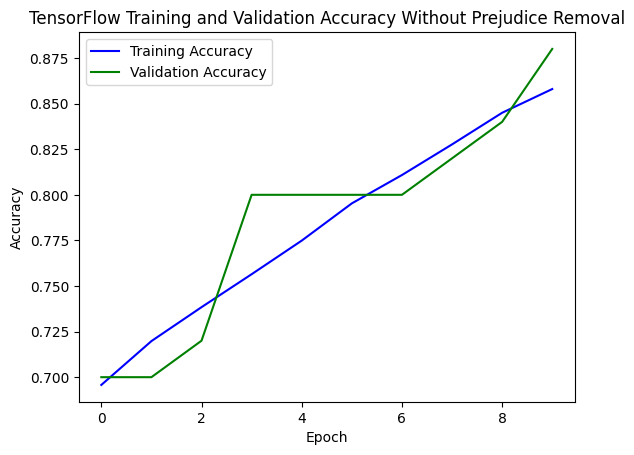

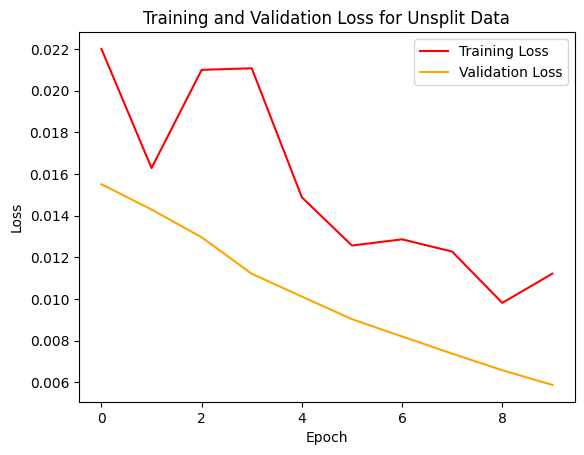

In [25]:
import matplotlib.pyplot as plt

# Train the model with normalized data
history = model.fit(X_train_normalized, Y_train, epochs=10, batch_size=32, validation_data=(X_test_normalized[:50], Y_test[:50]))


# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('TensorFlow Training and Validation Accuracy Without Prejudice Removal')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss for Unsplit Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Here, we split the data into privileged and unprivileged groups, and check the performance of our model with this split data using the prejudice removal regularizer.

In [9]:
evaluation = model.evaluate(X_test_normalized, Y_test)
priv.drop(columns=['juv_misd_count', 'decile_score'],inplace=True)
privX_train, privX_test, privY_train, privY_test = train_test_split(priv,priv_pred, test_size=0.5, random_state=42)

unpriv.drop(columns=['juv_misd_count', 'decile_score'],inplace=True)

unprivX_train, unprivX_test, unprivY_train, unprivY_test = train_test_split(unpriv,unpriv_pred, test_size=0.5, random_state=42)
privX_test_normalized = (privX_test - privX_test.mean(axis=0)) / privX_test.std(axis=0)
unprivX_test_normalized = (unprivX_test - unprivX_test.mean(axis=0)) / unprivX_test.std(axis=0)
# print("NaN values in Y_train:", np.any(np.isnan(privX_test)))
# print("NaN values in Y_test:", np.any(np.isnan(privY_test)))
priv_loss, priv_accuracy = model.evaluate(privX_test, privY_test)
print("Privileged Data Loss:", priv_loss)
print("Privileged Data Accuracy:", priv_accuracy)

unpriv_loss, unpriv_accuracy = model.evaluate(unprivX_test, unprivY_test)
print("Unprivileged Data Loss:", unpriv_loss)
print("Unprivileged Data Accuracy:", unpriv_accuracy)

39/39 [==============================] - 1s 5ms/step - loss: 0.5542 - accuracy: 0.7359
Privileged Data Loss: 0.554233968257904
Privileged Data Accuracy: 0.7359412908554077
58/58 [==============================] - 0s 3ms/step - loss: 1.0351 - accuracy: 0.5676
Unprivileged Data Loss: 1.0351169109344482
Unprivileged Data Accuracy: 0.5676407217979431


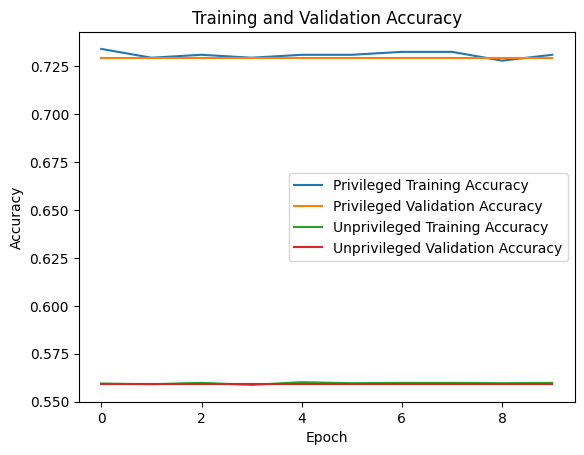

In [20]:
history_priv = model.fit(privX_test_normalized, privY_test, epochs=10, batch_size=32, validation_data=(privX_test_normalized, privY_test), verbose=0)
history_unpriv = model.fit(unprivX_test_normalized, unprivY_test, epochs=10, batch_size=32, validation_data=(unprivX_test_normalized, unprivY_test), verbose=0)

plt.plot(history_priv.history['accuracy'], label='Privileged Training Accuracy')
plt.plot(history_priv.history['val_accuracy'], label='Privileged Validation Accuracy')
plt.plot(history_unpriv.history['accuracy'], label='Unprivileged Training Accuracy')
plt.plot(history_unpriv.history['val_accuracy'], label='Unprivileged Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

From evaluating the model, there is significant parity between the privileged and unprivileged groups based on the accuracy. Our model is overfitting to label the unprivileged group as "good" or in this case, "negative" for two year recidivism. As a result, the model incorrectly predicts 30% of the unprivileged group while maintaining its original accuracy for the privileged group, without using `is_recid` as a feature.